# Johnsen-Diffusion model 2000
Johnsen, S.J., Clausen, H.B., Cuffey, K.M., Hoffmann, G. and Creyts, T.T., 2000. Diffusion of stable isotopes in polar firn and ice: the isotope effect in firn diffusion.<br>
https://academiccommons.columbia.edu/doi/10.7916/D8KW5D4X

# Diffusion equation (using isotopic diffusivity in firn)

# (I) $ \frac{\partial\delta}{\partial t} $ = $\Omega_{fi}\frac{\partial^2 \delta}{\partial z^2} $

#### Import packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#### Interpolation function

In [6]:
from scipy.interpolate import interp1d
def intp(data, x_orig, x_new):
    """ This function interpolates 1D data to a new resolution.
        data: 1D data
        x_orig: original dependency of the data, e.g. time or depth
        x_new: new dependency to be interpolated on, e.g. higher time resolution
    """
    f=interp1d(x_orig, data)
    return f(x_new)

#### Fractionation coefficient functions for T<0 °C

In [8]:
def alphaD_MN(T):
    ''' fractionation factor for Deuterium alpha_ice/vapour (Merlivat & Nief 1967)
    -40°C bis 0°C, input Temperature in °C:'''
    if np.any(T>0):
        print('ERROR alpha: T='+str(np.round(T,2))+' above 0 °C')    
    # for alpha_vapour/ice simply 1/alphaD
    TK=T+273.15 # T in K 
    #log alphaD=-4.1*1e-2+(7.074/(T**2)) #the original in the paper using log(10)
    alphaD=np.exp(-9.45*1e-2+(16.289*1e3/(TK**2))) #also given in MN paper on page 125
    return alphaD

def alpha18O_Maj(T):
    ''' fractionation coefficient for 18O alpha_ice/vapour (Majoube 1971b):
    from 0°C- -33.4°C, give Temperature (T) in K'''
    if np.any(T>0):
        print('ERROR alpha: T='+str(np.round(T,2))+' above 0 °C')
    # for alpha_vapour/ice simply 1/alpha18O
    TK=T+273.15  # T in K 
    alpha18O=np.exp((11.839/TK)-28.224*1e-3)
    return alpha18O


#### Johnsen 2000 Diffusion Model function

In [13]:
def calc_omegafirn(T,P,rho_s):
    ''' This function calculates the isotopic diffusivity in firn according to Johnsen et al. (2000) model using the proposed way
   t     to calculate saturation vapor pressure and fractionation factors by Majoube, Merlivat, and Nief
    input: 
        T= Temperature of firn in °C
        P= Pressure at site in hPa
        rho_s = density of snow kg/m3
    output diffusivities: 
        omega_18O, omega_D in m2/s'''
    T0=273.15 # 0°C in Kelvin
    TK=T+T0 # input temperature in Kelvin
    P0=1013.25 # sea surface air pressure (hPa)
    rho_ice=917 # density of ice (kg/m3)

    # calculate leading coefficient (mP/RT):
    molarwt = 18.015/1000 # molar weight of water (kg/mol)
    Rgas = 8.314 # J/mol-K  %% gas constant
    Psat = 3.454e12 * np.exp(-6133/TK) # saturation vapor pressure over ice in Pascals;  formula used by Johnsen
    mPRT = molarwt*Psat/(Rgas*TK) # final values for leading coefficient (mP/RT):

    # calculate diffusivity of water vapor in open air (Omega_a)
    # Johnsen method (Eq.19 Johnsen2000; from Hall and Pruppacher 1976)
    D_18O = 1.0285 # diffusivity of 18O
    D_D = 1.0251 # diffusivity of Deuterium (D)
    Omega_air = 0.211 * (TK/T0) ** 1.94  * (P0/P) # Diffusivity of water vapor in air, in cm^2/s, accurance 5-10% 
    Omega_air = Omega_air * 1e-4 # convert to unit m^2/s

    # isotopic diffusivity in air (m^2 / s)
    Omega_air18 = Omega_air/D_18O # diffusivity of 18O in air
    Omega_airD = Omega_air/D_D # diffusivity of D in air

    # tortuosity factor
    b = 1.3 # constant
    tauinv = 1-b*(rho_s/rho_ice)**2 

    # isotopic diffusivity in firn (m^2 / s)
    omega_18O = mPRT*Omega_air18*tauinv/alpha18O_Maj(T)*((1/rho_s)-(1/rho_ice)) #use Majoube 
    omega_D = mPRT*Omega_airD*tauinv/alphaD_MN(T)*((1/rho_s)-(1/rho_ice)) #use Merlivat and Nief
    return omega_18O, omega_D

In [15]:
#### Cranck nicholson matrix to weight diffusion

In [17]:
def crank_nicolson_matrix(n_layer):
    """ This function sets up the Crank-Nicolson matrix for Diffusion
    """
    A=np.diag(np.ones(n_layer-1), k=-1)+np.diag(np.ones(n_layer-1), k=1) # create matrix and fill the diagonals above and below the main diagonal with ones
    np.fill_diagonal(A,-2) # is inplace=True
    A[0,0]=-1 #set upper boundary conditions
    A[-1,:]=0
    #A[-1,-1]=0
    #A[-1,-2]=0 # lower boundary is slap that is not influenced by the above
    return A

## Run diffusion model

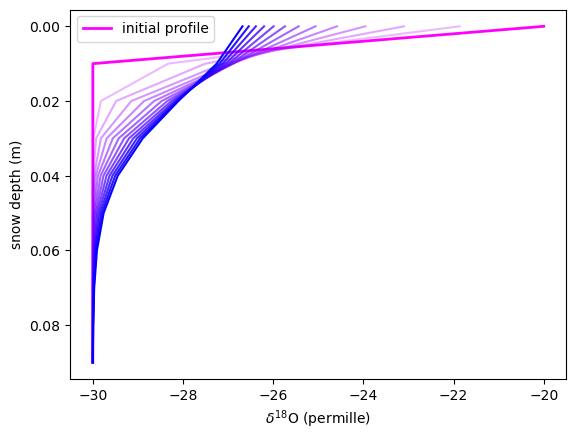

In [21]:
dz = 0.01 # vertical resolution in m (here 1 cm)
dindex = np.arange(0,0.1, dz) # vertical model grid: snow depth in m; here 0 to 10 cm

d18o = np.full(10,-30) # the profile is 10 cm deep and has an initial value of -30 permille
d18o[0] = -20 # set the surface value to -20 instead of -30
plt.plot(d18o, dindex, color=[1,0,1], lw=2)
plt.xlabel(r'$\delta^{18}$O (permille)')
plt.ylabel('snow depth (m)')
plt.legend(['initial profile'])
plt.gca().invert_yaxis() # turn the figure upside down, so that snow depth is shown instead of height

omega_18O, omega_D = calc_omegafirn(T=-35, P=700, rho_s=300) # calculate diffusivities with Johnson diffusion model
A=crank_nicolson_matrix(n_layer=len(d18o)) # diffusion weight matrix

dt=24*60*60 # model time step in seconds; here one day

for i in range(365): # loop over one year
    d18o = d18o + omega_18O/(dz**2) * np.dot(A, d18o) * dt # diffusion d18O
    if i%30==29: # plot only once at the end of a month
        plt.plot(d18o, dindex, color=[(365-i)/450,0,1, (i+100)/465])  # colors [red, green, blue, alpha]

### Plotting function to diffuse and plot a snow profile

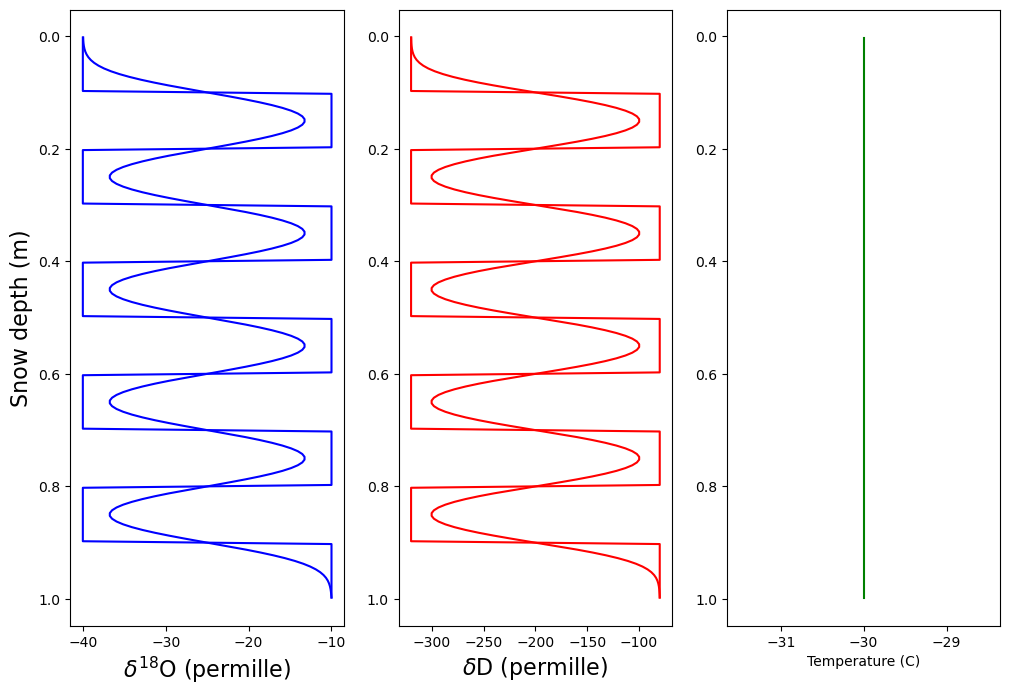

In [23]:
# Plot the initial snow isotope profile
def diffuse_and_plot_snow_profile(d18o, dd, t, p, rho_s, colors='normal', ax=None):
    """ This function applies the diffusion model to
        initial isotope profiles for d18O and dD:  d18o, dd
        for a given temperature: t , pressure: p ,  snow density: rho_s.
        The model's time step: dz=5mm , and vertical resolution dt=1 day are fixed.
        colors: a list of two color lists [red_value, green_value, blue_value] for the diffused d18O and dD profiles
    """
    # plot colorscheme
    if colors=='normal': colors=[[0,0,1],[1,0,0]]
    elif colors=='light': colors=[[0.2,0.7,1],[1,0.8,0.6]]
    elif colors== 'dark': colors=[[0,0,0.6],[0.6,0,0]]
    else: print('choose a colorscheme for parameter "colors": "normal", "light", "dark".')
        
    # vertical model grid
    dz=5e-3 # vertical depth of one layer, default: 5mm in m
    dindex=np.arange(0+dz/2,dz*len(d18o),dz) # vertical grid
    # time step
    dt=24*60*60 # length of model time step in seconds, default: 1 day in seconds

    A=crank_nicolson_matrix(n_layer=len(d18o)) # diffusion weight matrix
    omega_18O, omega_D = calc_omegafirn(t, p, rho_s) # calculate diffusivities with Johnson diffusion model

    if ax==None: fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12,8))
    else: ax1, ax2, ax3 = ax
    ax1.plot(d18o, dindex, color=[0,0,1])
    ax1.set_xlabel(r'$\delta^{18}$O (permille)', fontsize=16)
    ax1.set_ylabel('Snow depth (m)', fontsize=16)

    ax2.plot(dd, dindex, color=[1,0,0])
    ax2.set_xlabel(r'$\delta$D (permille)', fontsize=16)
    
    for i in range(365): # loop over one year (365*dt)
        d18o = d18o + omega_18O/(dz**2) * np.dot(A, d18o) * dt # diffusion d18O
        dd = dd + omega_D/(dz**2) * np.dot(A, dd) * dt # diffusion dD
    ax1.plot(d18o, dindex, color=colors[0])
    ax2.plot(dd, dindex, color=colors[1])
    
    #temperature
    ax3.plot(t, dindex, color=[0,0.5,0])
    ax3.set_xlabel('Temperature (C)')

    if not ax1.yaxis_inverted(): # invert depth y-axis, but only once
        ax1.invert_yaxis() # turn y axis upside down
        ax2.invert_yaxis()
        ax3.invert_yaxis()

    return d18o,dd




# initialize artificial isotope data
d18o=np.tile([-40,-10], (20,5)).T.ravel()  # fake d18O values for 10 years, -40 in winter, -10 in summer = total 20 seasons
dd = 8*d18o # calculate dD from d18O with constant d-excess

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12,8))

# Constant annual mean temperature
t = np.full(len(d18o),-30) # snow temperature profile
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700, rho_s=300, ax=[ax1, ax2, ax3])



# Exercise
__answer the following questions:__
1. Which effect do temperature, snow density, and pressure have on the isotope diffusion
2. How does diffusion affect the d-excess profile?
3. Which effect does a seasonal temperature profile have?

### Solution to 1.

__temperature sensitivity__

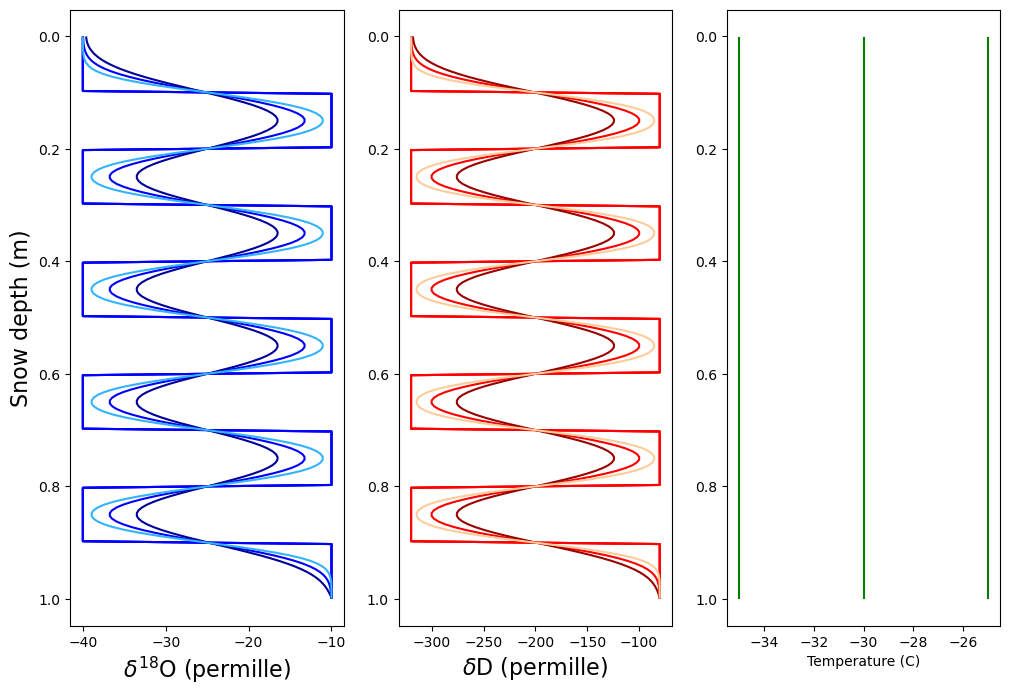

In [28]:
d18o=np.tile([-40,-10], (20,5)).T.ravel()  # fake d18O values for 10 years, -40 in winter, -10 in summer = total 20 seasons
dd = 8*d18o # calculate dD from d18O with constant d-excess

# plot results
# temperature sensitivity:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12,8))
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700, rho_s=300, ax=[ax1, ax2, ax3]) # diffused with a constant temperature
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t+5, p=700, rho_s=300, ax=[ax1, ax2, ax3], colors='dark') # diffused with a constant temperature
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t-5, p=700, rho_s=300, ax=[ax1, ax2, ax3], colors='light') # diffused with a constant temperature

__pressure sensitivity__

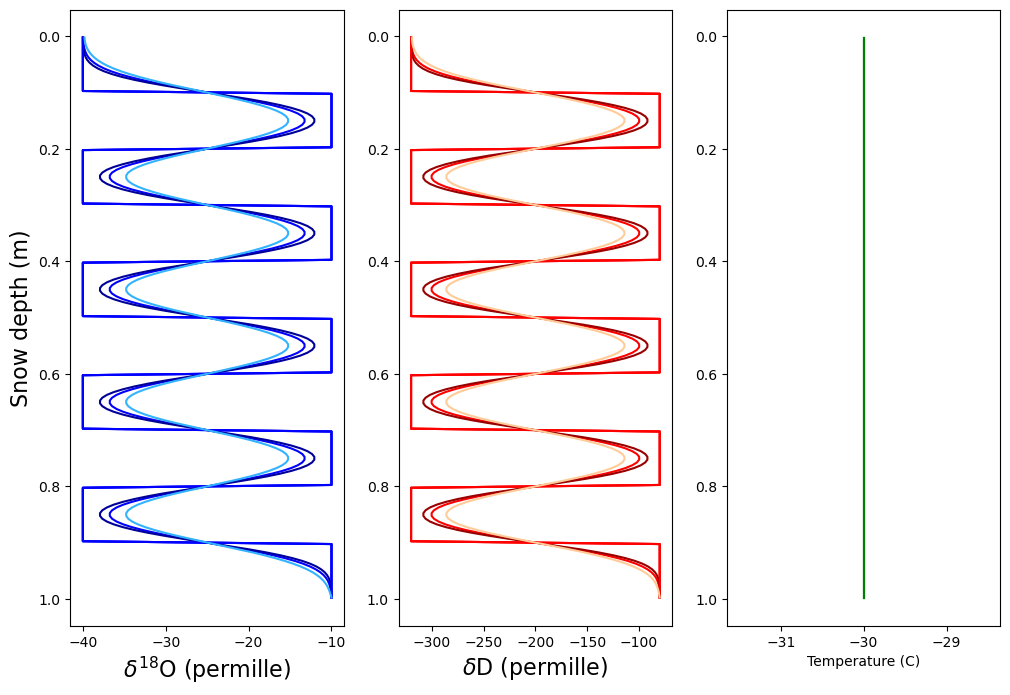

In [31]:
# plot results
# pressure sensitivity:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12,8))
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700, rho_s=300, ax=[ax1, ax2, ax3]) # diffused with a constant temperature
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700+200, rho_s=300, ax=[ax1, ax2, ax3], colors='dark') # diffused with a constant temperature
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700-200, rho_s=300, ax=[ax1, ax2, ax3], colors='light') # diffused with a constant temperature


__density sensitivity__

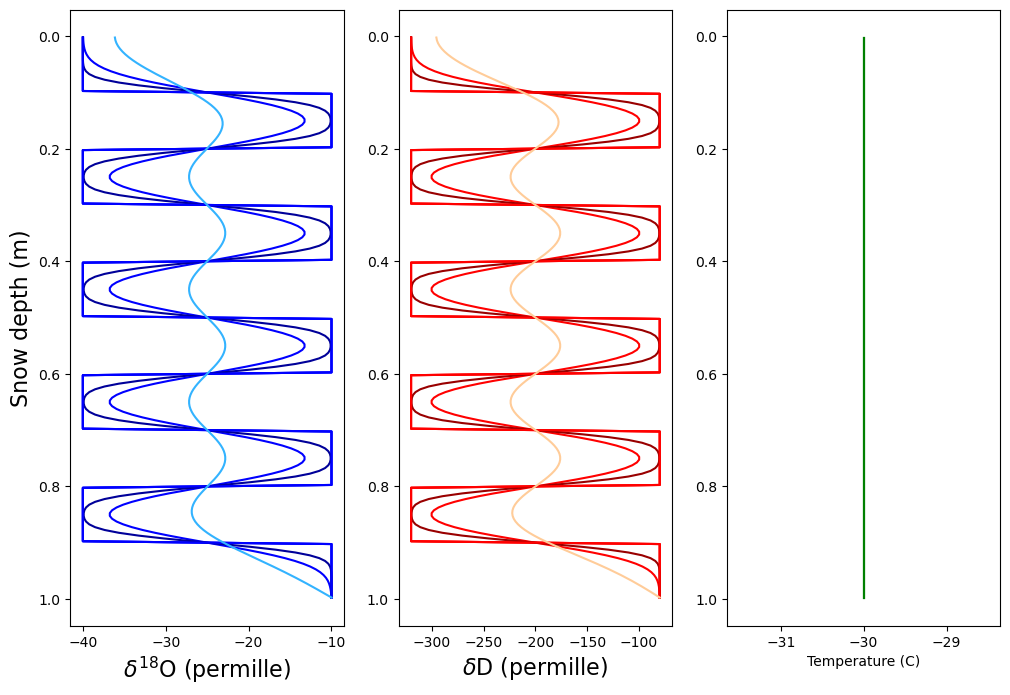

In [34]:
# plot results
# density sensitivity:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12,8))
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700, rho_s=300, ax=[ax1, ax2, ax3]) # diffused with a constant temperature
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700, rho_s=300+200, ax=[ax1, ax2, ax3], colors='dark') # diffused with a constant temperature
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700, rho_s=300-200, ax=[ax1, ax2, ax3], colors='light') # diffused with a constant temperature

### Solution to 2.

Text(0, 0.5, 'snow depth (m)')

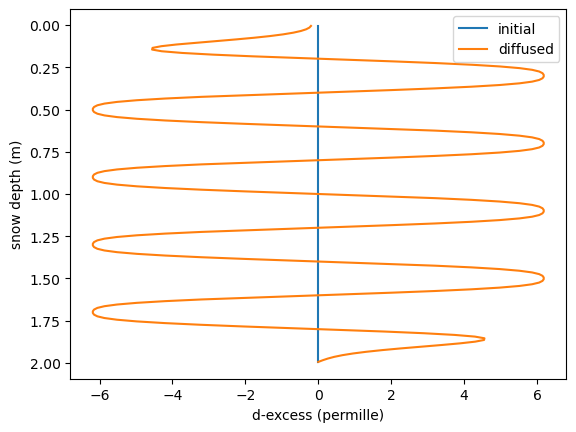

In [37]:
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700, rho_s=300, ax=[ax1, ax2, ax3]) # diffused with a constant temperature

dxs=dd - 8*d18o
dxs_diff = dd_diff - 8*d18o_diff
dindex=np.arange(0+dz/2,dz*len(d18o),dz) # vertical grid

plt.plot(dxs, dindex)
plt.plot(dxs_diff, dindex)
plt.gca().invert_yaxis()
plt.xlabel('d-excess (permille)')
plt.legend(['initial','diffused'])
plt.ylabel('snow depth (m)')


### Solution to 3.

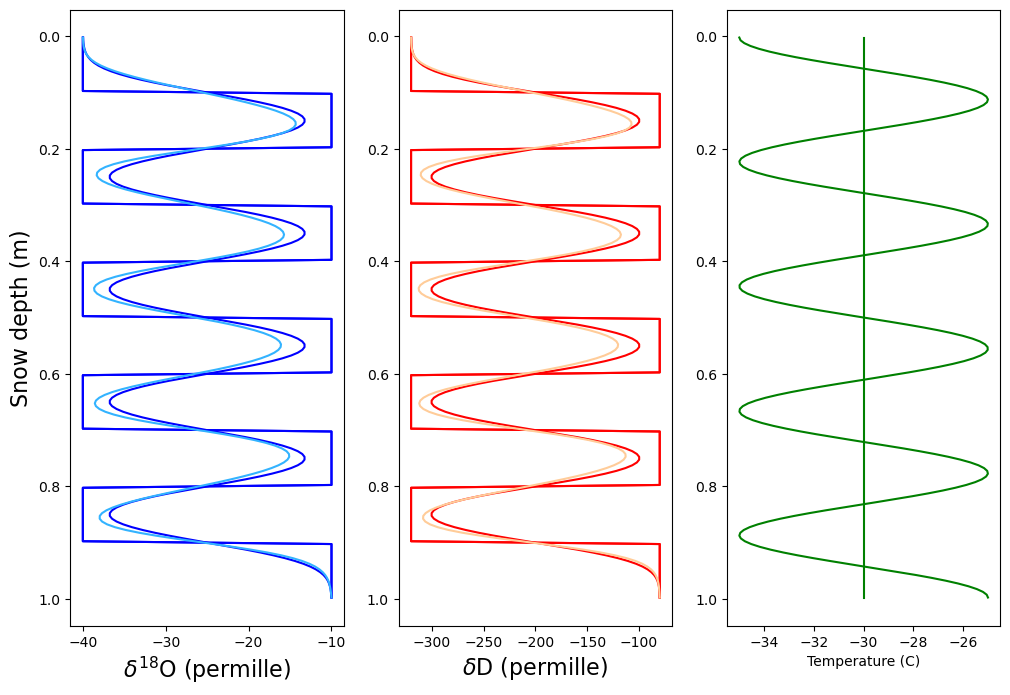

In [40]:
# initialize artificial isotope data
d18o=np.tile([-40,-10], (20,5)).T.ravel()  # fake d18O values for 10 years, -40 in winter, -10 in summer = total 20 seasons
dd = 8*d18o # calculate dD from d18O with constant d-excess

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12,8))

# Constant annual mean temperature
t = np.full(len(d18o),-30) # snow temperature profile
d18o_diff, dd_diff = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700, rho_s=300, ax=[ax1, ax2, ax3]) # diffused with a constant temperature

# Temperature with seasonal cycle
t = -5*np.cos(np.linspace(0,9*np.pi,len(d18o)))-30
d18o_diff_seas, dd_diff_seas = diffuse_and_plot_snow_profile(d18o, dd, t=t, p=700, rho_s=300, ax=[ax1, ax2, ax3], colors='light') # diffused with a seasonally varying temperature